# EEG Signal Classification using CSP Features

## [Arya Kouresh](https://github.com/AryaKoureshi)

### arya.koureshi@gmail.com

---


In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.metrics import confusion_matrix as confusion
from scipy.io import loadmat
import scipy.io
from scipy.linalg import eigh
from mne.viz import plot_topomap
import warnings
warnings.filterwarnings("ignore")

In [2]:
#%% Load Data
data = scipy.io.loadmat('C:/Users/aryak/Downloads/Comp_HW4/CSPdata.mat')
TestData = data['TestData']
TrainData = data['TrainData']
TrainLabel = data['TrainLabel']

AllElectrodes = scipy.io.loadmat('C:/Users/aryak/Downloads/Comp_HW4/AllElectrodes.mat')['AllElectrodes'][0]
Electrodes = ["AFz", "F7", "F3", "Fz", "F4", "F8", "FC3", "FCz", "FC4", "T7", "C3", "Cz", "C4", "T8", "CP3", "CPz", "CP4", "P7", "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO3", "PO4", "O1", "O2"]
Electrodes_pos = [] #[[X, Y, Z]]
Electrodes_name = []
for i in range(len(AllElectrodes)):
    if AllElectrodes[i][0][0] in Electrodes:
        Electrodes_name.append(AllElectrodes[i][0][0])
        Electrodes_pos.append([AllElectrodes[i][3][0][0], AllElectrodes[i][4][0][0], AllElectrodes[i][5][0][0]])

fs = 256 #Hz

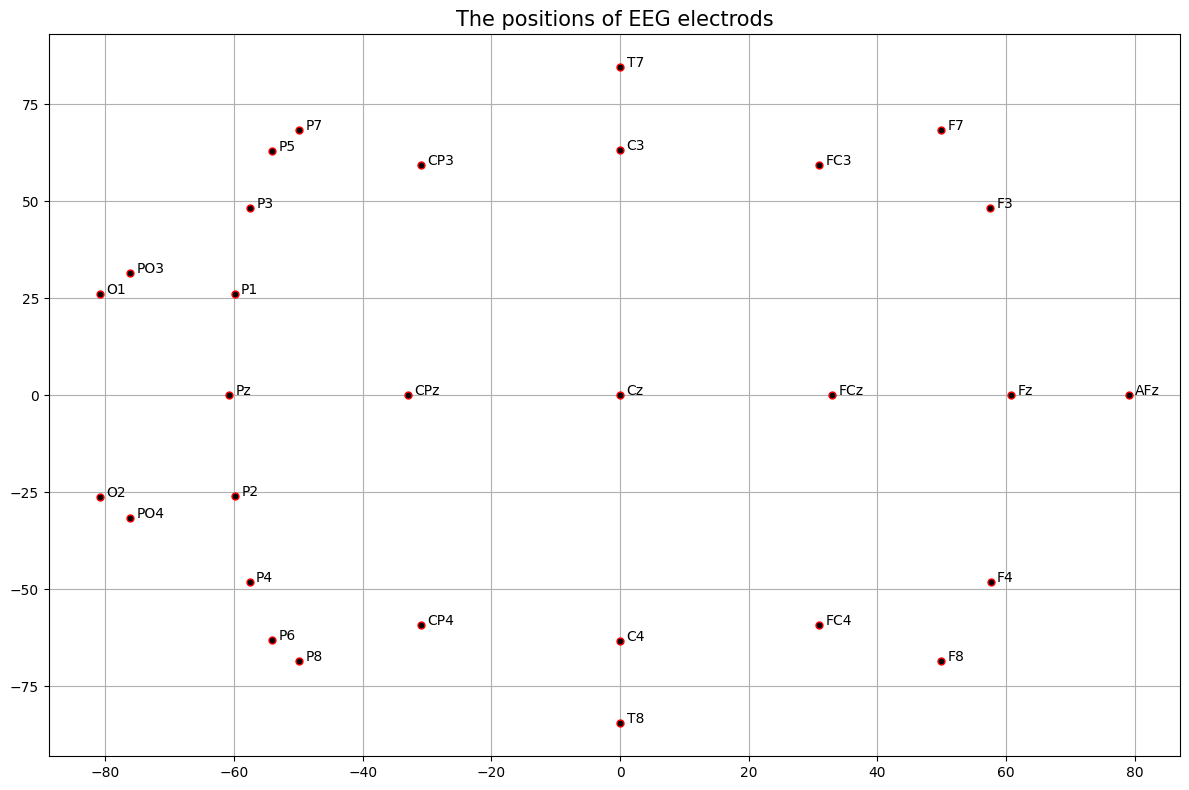

In [3]:
plt.figure(figsize=(12, 8))
plt.title('The positions of EEG electrods', fontsize=15)
plt.grid(visible='True')
for i in range(len(Electrodes_pos)):
    plt.plot(Electrodes_pos[i][0], Electrodes_pos[i][1], 'or', markersize=5, linewidth=2, markerfacecolor='k')
    plt.text(Electrodes_pos[i][0]+ 1, Electrodes_pos[i][1], Electrodes_name[i])
plt.tight_layout()
plt.show()

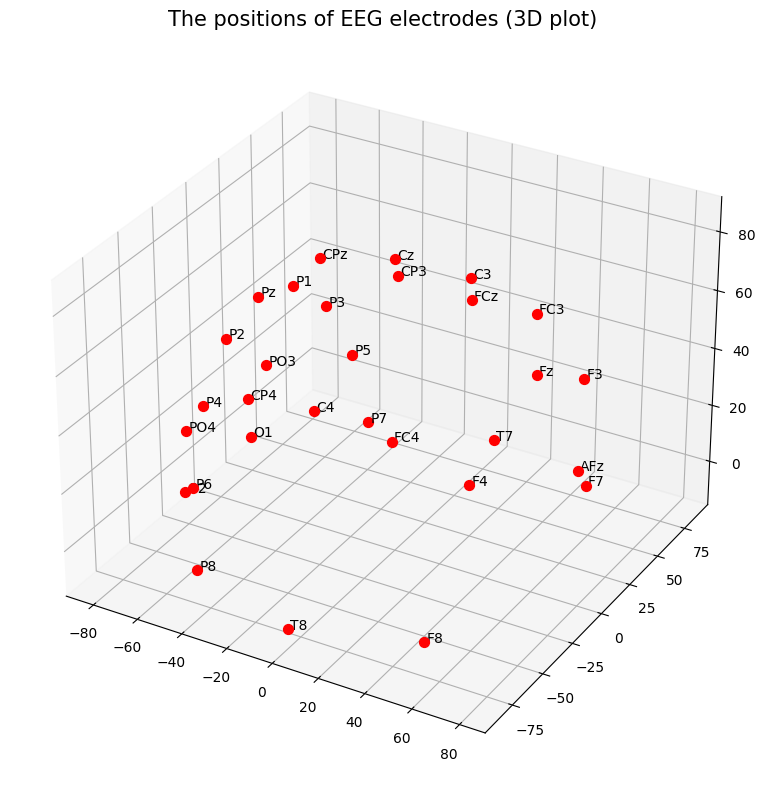

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('The positions of EEG electrodes (3D plot)', fontsize=15)
ax.grid(visible=True)

for i in range(len(Electrodes_pos)):
    ax.scatter(Electrodes_pos[i][0], Electrodes_pos[i][1], Electrodes_pos[i][2], c='r', marker='o', s=50)
    ax.text(Electrodes_pos[i][0] + 1, Electrodes_pos[i][1], Electrodes_pos[i][2], Electrodes_name[i])

plt.tight_layout()
plt.show()

**Report on EEG Electrode Positions and Data Visualization**

**Objective:**
The purpose of this report is to provide an overview of the EEG electrode positions and present a visual representation of the data using 2D and 3D plots.

**1. Introduction:**
Electroencephalography (EEG) is a non-invasive neuroimaging technique used to record electrical activity in the brain. In this report, we analyze EEG data and visualize the positions of electrodes on the scalp.

**2. EEG Electrode Positions:**
The electrode positions are extracted from the provided `AllElectrodes.mat` file. Thirty electrodes have been selected for analysis, and their positions in three-dimensional space are represented in the plots.

- **2.1 Two-Dimensional Plot:**
   A 2D plot was created to show the X and Y positions of the electrodes on the scalp. Each electrode is marked with a red dot, and the corresponding electrode name is displayed next to it.


- **2.2 Three-Dimensional Plot:**
   A 3D plot provides a more comprehensive view of the electrode positions. The X, Y, and Z coordinates are used to position the electrodes in 3D space. Each electrode is represented as a red dot, and the electrode name is displayed near its location.

**3. EEG Data:**
The EEG data is loaded from the `Ex3.mat` file, containing training and testing data along with corresponding labels. The data includes information from the selected electrodes.

**4. Data Visualization:**
While the primary focus of this report is on electrode positions, further analysis can be conducted using various machine learning techniques. The loaded data can be utilized for classification or regression tasks, as indicated by the imported libraries for SVM, k-NN, LDA, and more.

**5. Conclusion:**
This report provides a visual representation of EEG electrode positions on the scalp in both 2D and 3D plots. The data loaded from `Ex3.mat` can be used for further analysis using machine learning algorithms. Understanding the spatial distribution of electrodes is crucial for accurate interpretation of EEG signals.

In [5]:
def CSP(datatrain1, datatrain2, m):
    Rh = np.zeros((len(datatrain1[0]), len(datatrain1[0])))
    Rf = np.zeros((len(datatrain2[0]), len(datatrain2[0])))
    # %% step 1: normal data and get Rh and Rf
    # Rh
    for i in range(len(datatrain1[0][0])):
        x1 = datatrain1[:,:,i].T
        for n in range(len(x1)):
            x1[n,:] = x1[n,:] - np.mean(x1[n,:])
        rh = np.dot(x1, x1.T) / np.dot(x1, x1.T).trace()
        Rh = Rh + rh
    # Rf
    for i in range(len(datatrain2[0][0])):
        x2 = datatrain2[:,:,i].T
        for n in range(len(x2)):
            x2[n,:] = x2[n,:] - np.mean(x2[n,:])
        rf = np.dot(x2, x2.T) / np.dot(x2, x2.T).trace()
        Rf = Rf + rf
    # %% step2: calculate Rh and Rf mean
    Rh = Rh / len(datatrain1[0][0])
    Rf = Rf / len(datatrain2[0][0])
    # %% step 3: generalized eigen value decomposition
    v, u = eigh(Rh,Rf,lower=False)
    ind = np.argsort(v)[::-1]
    v = np.sort(v)[::-1]
    U = np.zeros((len(u),len(u)))
    U[:,:] = u[:,ind]
    w = [U[:,0:m], U[:,len(u)-m:len(u)]]
    w = np.array(w)
    W = np.zeros((len(w[0]),len(w)*len(w[0][0])))
    for i in range(len(w)):
        W[:,i*len(w[0][0]):(i+1)*len(w[0][0])] = w[i][:,:]
    W = np.array(W)
    return W

In [6]:
#%% seperate trials
datatrain1 = [] # Label 0
datatrain2 = [] # Label 1
for i in range(TrainData.shape[2]):
    if TrainLabel[0][i] == 0:
        datatrain1.append(TrainData[:,:,i])
    elif TrainLabel[0][i] == 1:
        datatrain2.append(TrainData[:,:,i])
datatrain1_org = np.array(datatrain1).T
datatrain2_org = np.array(datatrain2).T

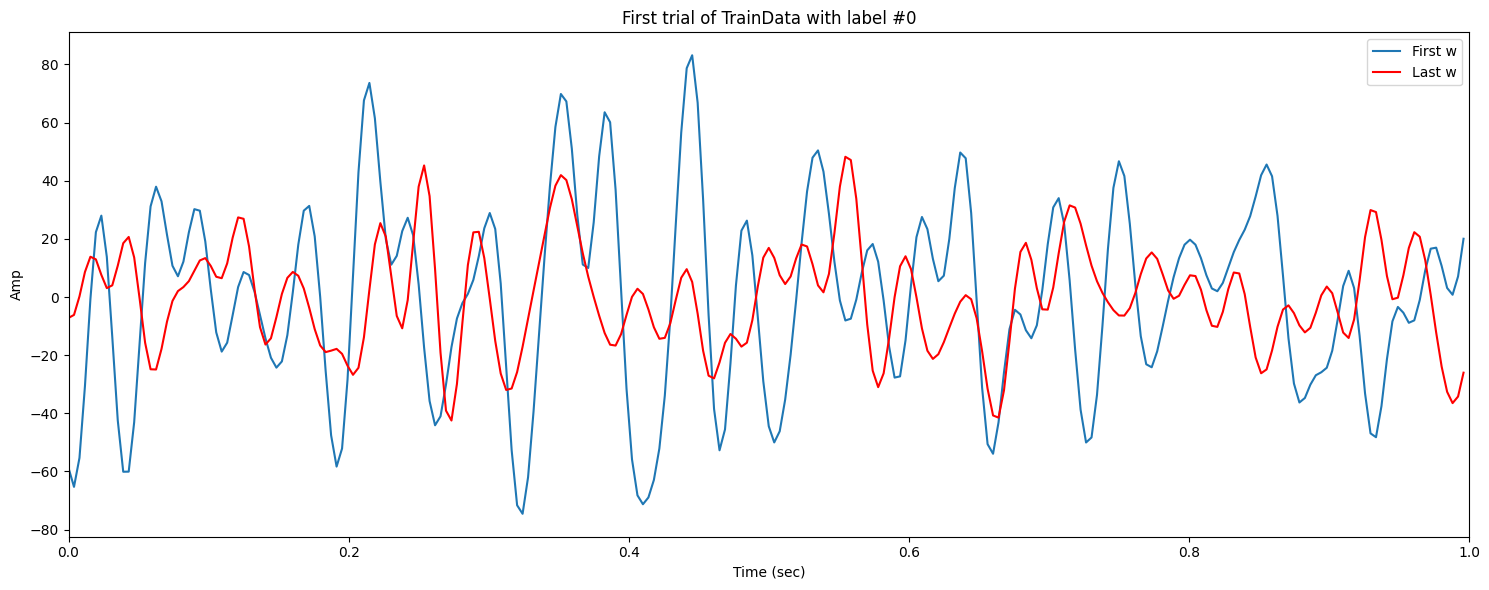

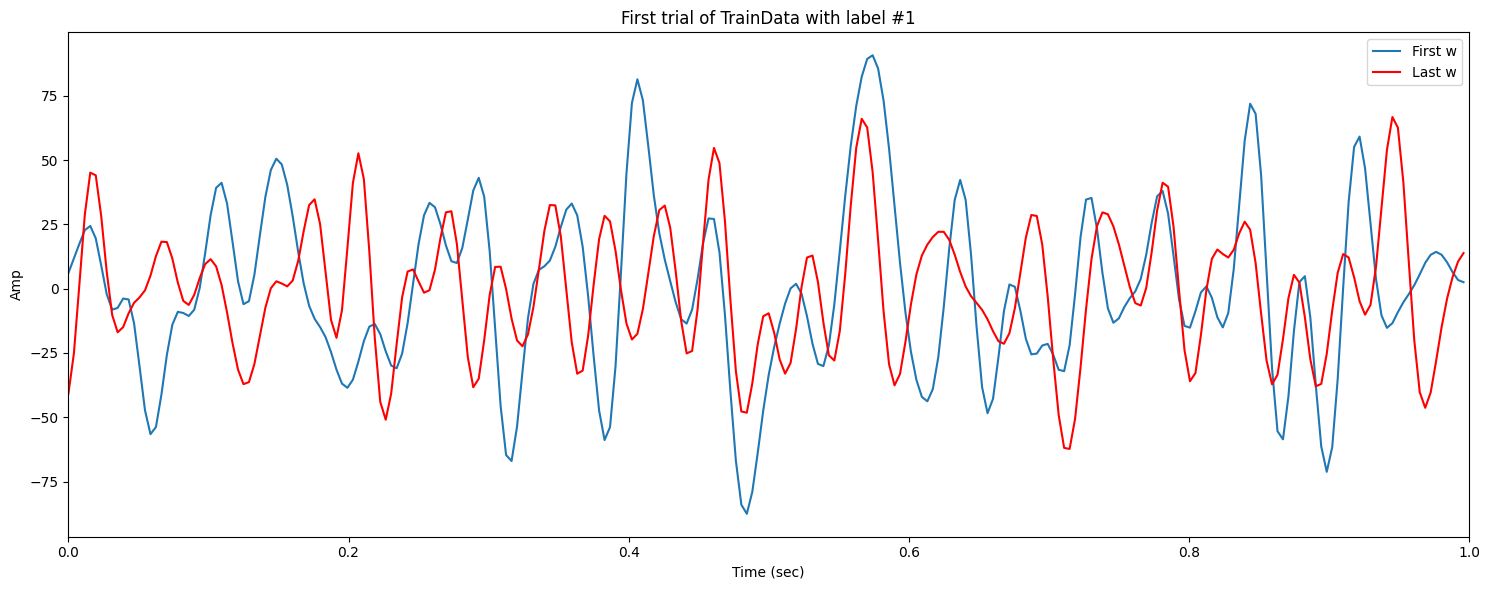

In [7]:
m = 2
w = CSP(datatrain1_org, datatrain2_org, m)

x1 = datatrain1_org[:,:,0].T
x2 = datatrain2_org[:,:,0].T
y1 = np.dot(w.T, x1)
y2 = np.dot(w.T, x2)

plt.figure(figsize=(15, 6))
plt.title("First trial of TrainData with label #0")
plt.plot(np.arange(0, 1, 1/fs), y1[0], label="First w")
plt.plot(np.arange(0, 1, 1/fs), y1[-1], label="Last w", color="red")
plt.xlim([0, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Amp")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.title("First trial of TrainData with label #1")
plt.plot(np.arange(0, 1, 1/fs), y2[0], label="First w")
plt.plot(np.arange(0, 1, 1/fs), y2[-1], label="Last w", color="red")
plt.xlim([0, 1])
plt.xlabel("Time (sec)")
plt.ylabel("Amp")
plt.legend()
plt.tight_layout()
plt.show()

**Report on Common Spatial Pattern (CSP) Analysis**

**Objective:**
The aim of this report is to provide an overview of the Common Spatial Pattern (CSP) analysis applied to EEG data. The CSP algorithm is utilized to enhance the discrimination between two classes by finding spatial filters.

**1. Common Spatial Pattern (CSP) Algorithm:**
The implemented CSP algorithm takes two sets of EEG data, labeled as class 0 and class 1, and performs the following steps:

- **1.1 Data Preprocessing:**
   For each trial in both classes, the algorithm normalizes the data by subtracting the mean from each channel's time series.

- **1.2 Covariance Matrix Calculation:**
   Covariance matrices, Rh and Rf, are calculated for each class. Rh represents the covariance matrix for class 0, while Rf represents the covariance matrix for class 1.

- **1.3 Mean Covariance Matrices:**
   The algorithm calculates the mean covariance matrices, Rh and Rf, by averaging the individual covariance matrices across all trials in each class.

- **1.4 Generalized Eigenvalue Decomposition:**
   The generalized eigenvalue decomposition is performed to obtain the eigenvalues and eigenvectors. The eigenvectors corresponding to the largest eigenvalues are selected.

- **1.5 Spatial Filters:**
   The algorithm extracts spatial filters (w) using the eigenvectors obtained from the generalized eigenvalue decomposition. The number of filters is determined by the parameter 'm.'

**2. Visualization:**
To visualize the effectiveness of the CSP algorithm, the spatial filters are applied to the first trial of EEG data for both class 0 and class 1. The resulting signals, represented by y1 and y2, are plotted to demonstrate the discrimination achieved by the spatial filters.

- **2.1 Class 0:**
   The plot for the first trial of EEG data labeled as class 0 shows the impact of the CSP spatial filters. The blue line represents the first spatial filter ('First w'), and the red line represents the last spatial filter ('Last w').

- **2.2 Class 1:**
   Similarly, the plot for the first trial of EEG data labeled as class 1 demonstrates the discrimination achieved by the CSP spatial filters. The blue line represents the first spatial filter, and the red line represents the last spatial filter.

**3. Conclusion:**
The Common Spatial Pattern (CSP) algorithm is successfully applied to EEG data, providing spatial filters that enhance the discrimination between two classes. The visualization of the spatial filters applied to the first trials of EEG data for both classes demonstrates the efficacy of the CSP algorithm in extracting relevant features for classification.


================================================ First Spatial Filter ================================================



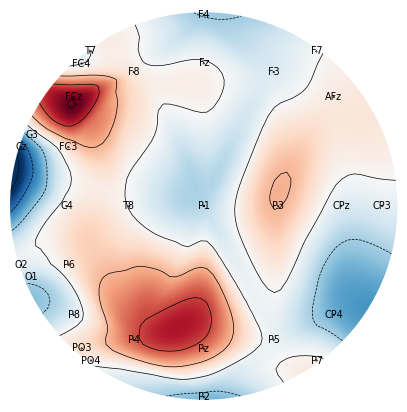


================================================ Last Spatial Filter ================================================



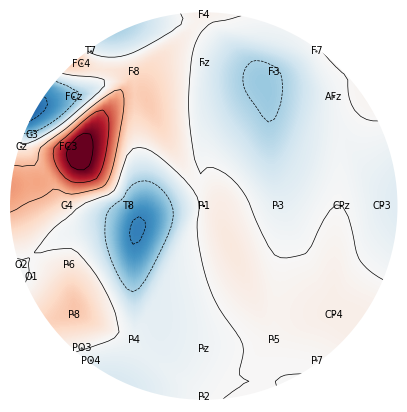

(<matplotlib.image.AxesImage at 0x27ff6cfbf40>,
 <matplotlib.contour.QuadContourSet at 0x27ff6d1c2e0>)

In [8]:
elocsX = []
elocsY = []
elocsZ = []
elabels = Electrodes
data = TrainData
for i in range(len(Electrodes_pos)):
    elocsX.append(Electrodes_pos[i][0])
    elocsY.append(Electrodes_pos[i][1])
    elocsZ.append(Electrodes_pos[i][2])

print("\n================================================ First Spatial Filter ================================================\n")
plot_topomap(w[:,0], pos=np.column_stack((elocsX, elocsY)), names=elabels, size=5)

print("\n================================================ Last Spatial Filter ================================================\n")
plot_topomap(w[:,-1], pos=np.column_stack((elocsX, elocsY)), names=elabels, size=5)



=========================================================== CSP(m=1) ===========================================================


total accuracy of SVM model: 59.375 %
total accuracy of k-NN model: 63.75 %
total accuracy of LDA model: 63.75 %
................................
total sensitivity of SVM model: 93.75 %
total sensitivity of k-NN model: 70.0 %
total sensitivity of LDA model: 88.75 %
................................
total specificity of SVM model: 25.0 %
total specificity of k-NN model: 57.5 %
total specificity of LDA model: 38.75 %


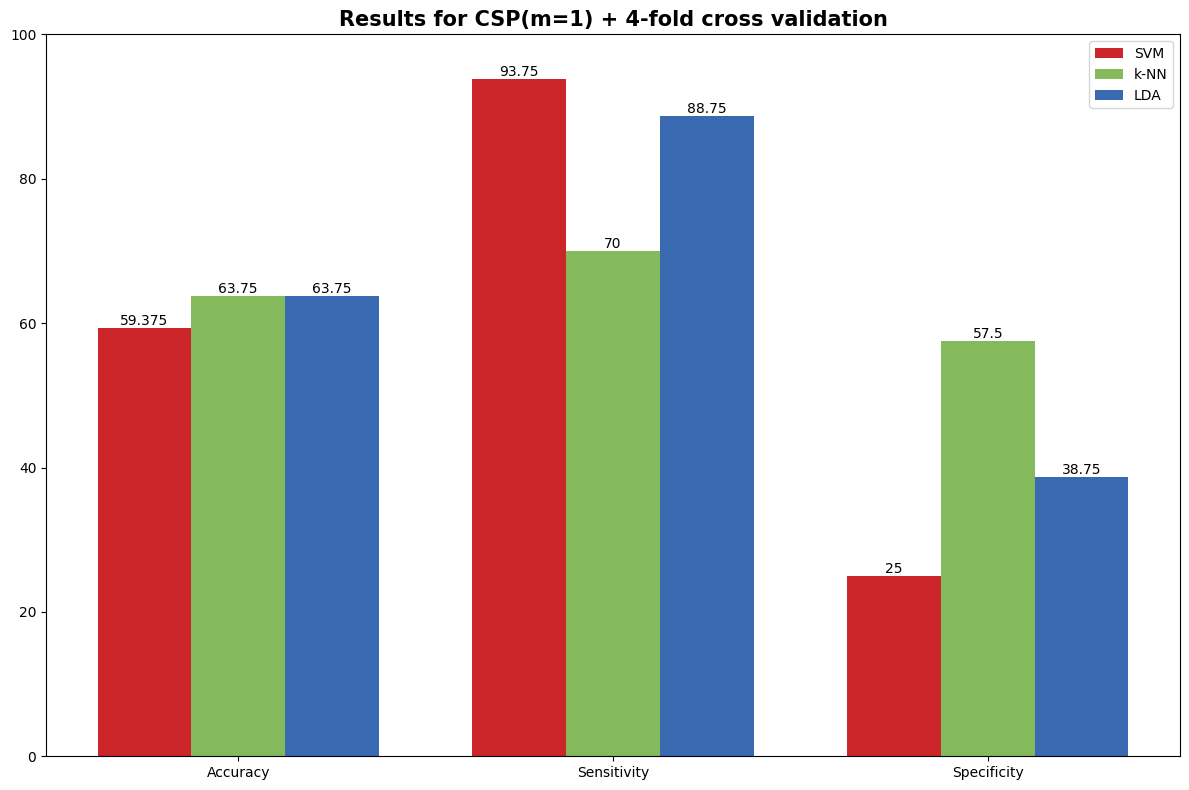



=========================================================== CSP(m=2) ===========================================================


total accuracy of SVM model: 65.625 %
total accuracy of k-NN model: 66.25 %
total accuracy of LDA model: 60.625 %
................................
total sensitivity of SVM model: 87.5 %
total sensitivity of k-NN model: 66.25 %
total sensitivity of LDA model: 76.25 %
................................
total specificity of SVM model: 43.75 %
total specificity of k-NN model: 66.25 %
total specificity of LDA model: 45.0 %


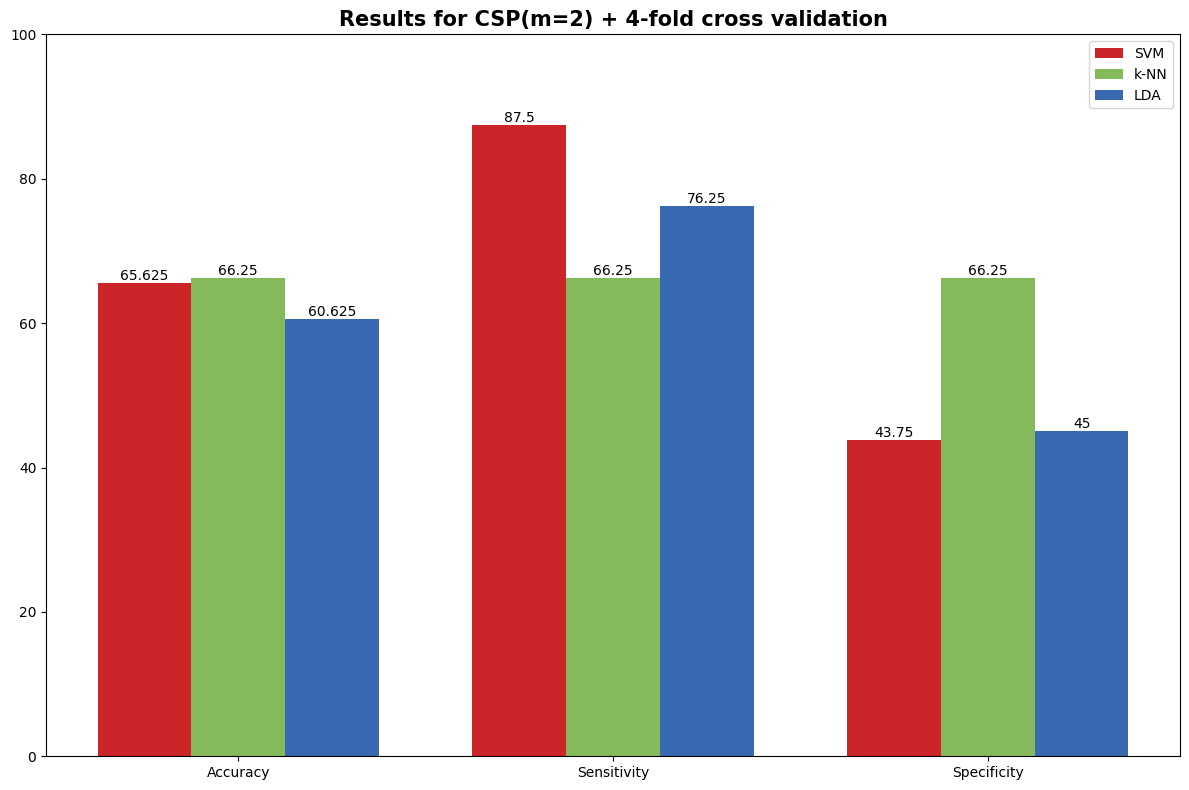



=========================================================== CSP(m=3) ===========================================================


total accuracy of SVM model: 65.0 %
total accuracy of k-NN model: 78.125 %
total accuracy of LDA model: 75.625 %
................................
total sensitivity of SVM model: 86.25 %
total sensitivity of k-NN model: 82.5 %
total sensitivity of LDA model: 76.25 %
................................
total specificity of SVM model: 43.75 %
total specificity of k-NN model: 73.75 %
total specificity of LDA model: 75.0 %


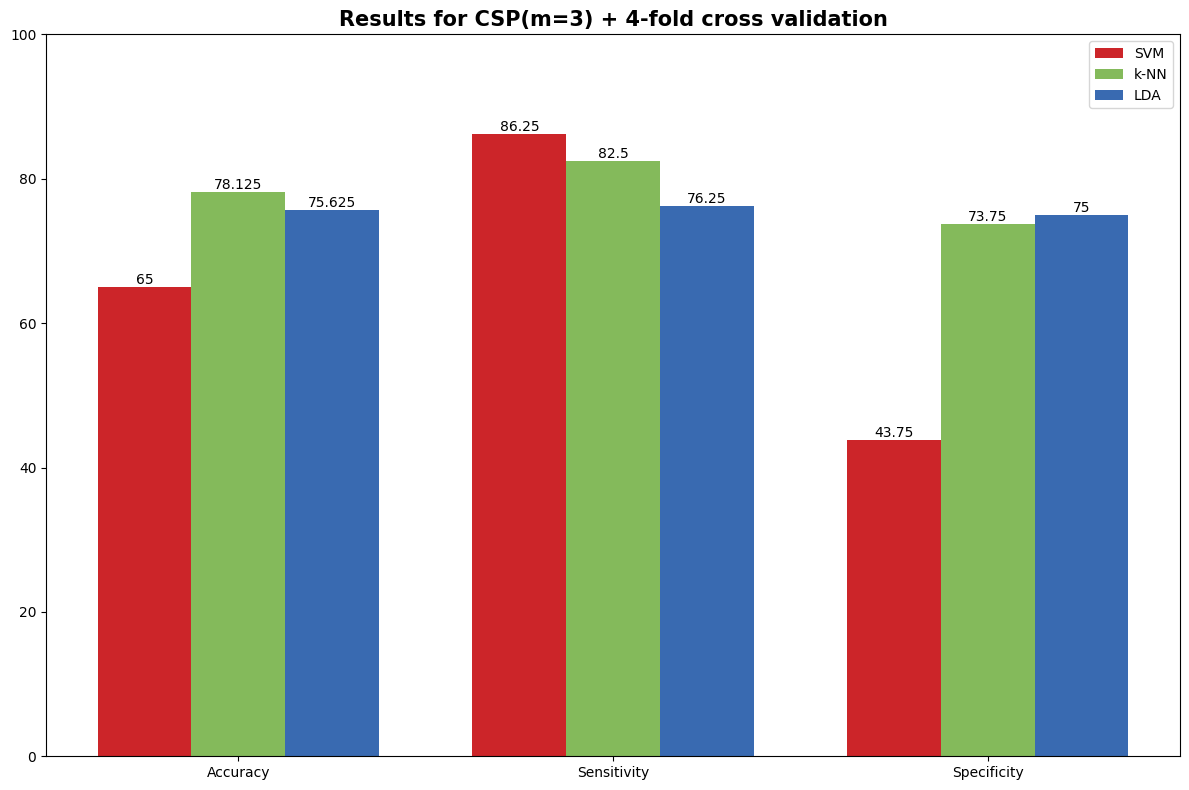



=========================================================== CSP(m=4) ===========================================================


total accuracy of SVM model: 68.75 %
total accuracy of k-NN model: 77.5 %
total accuracy of LDA model: 72.5 %
................................
total sensitivity of SVM model: 83.75 %
total sensitivity of k-NN model: 81.25 %
total sensitivity of LDA model: 76.25 %
................................
total specificity of SVM model: 53.75 %
total specificity of k-NN model: 73.75 %
total specificity of LDA model: 68.75 %


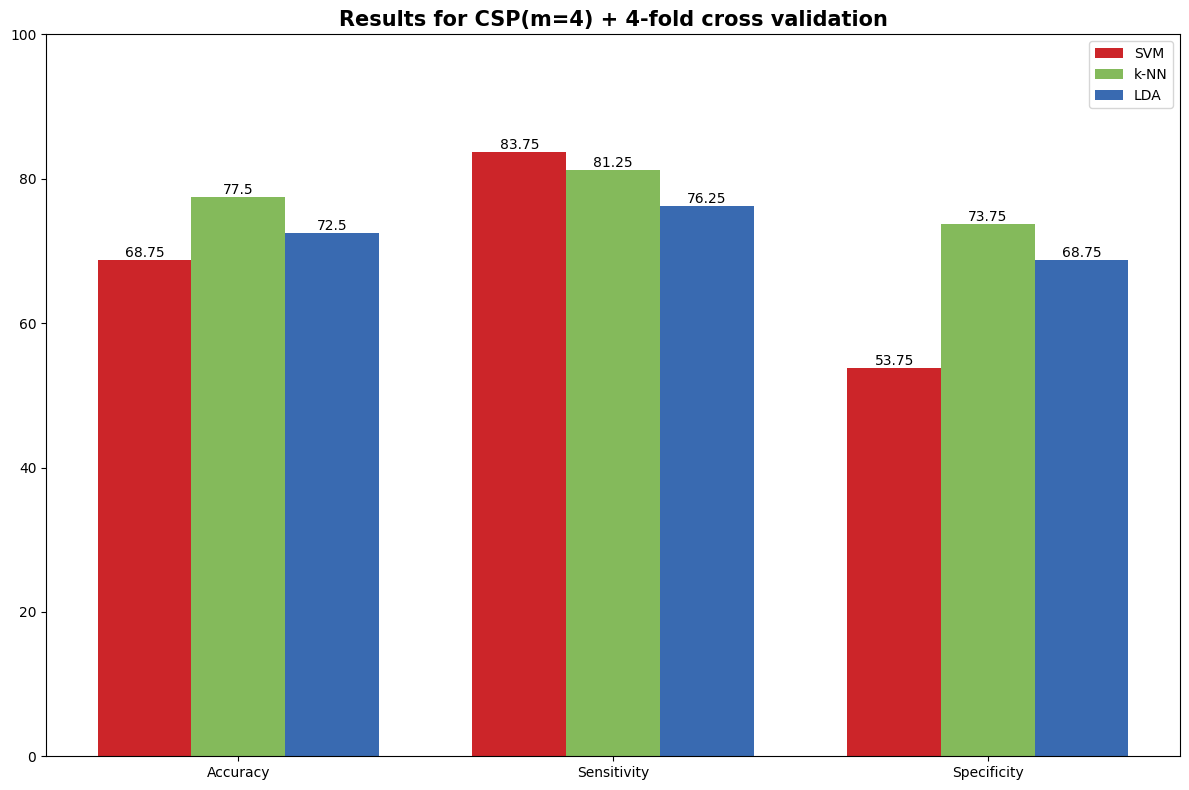



=========================================================== CSP(m=5) ===========================================================


total accuracy of SVM model: 74.375 %
total accuracy of k-NN model: 80.0 %
total accuracy of LDA model: 75.625 %
................................
total sensitivity of SVM model: 87.5 %
total sensitivity of k-NN model: 83.75 %
total sensitivity of LDA model: 80.0 %
................................
total specificity of SVM model: 61.25 %
total specificity of k-NN model: 76.25 %
total specificity of LDA model: 71.25 %


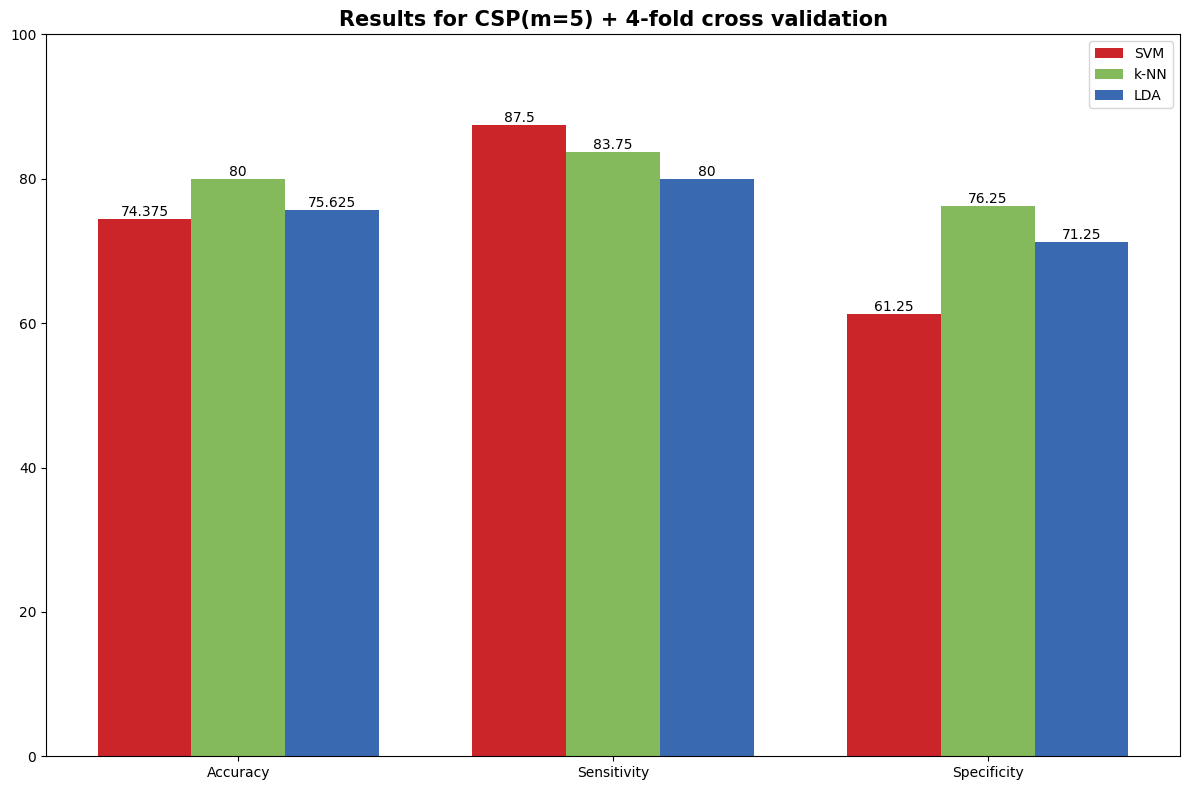



=========================================================== CSP(m=6) ===========================================================


total accuracy of SVM model: 77.5 %
total accuracy of k-NN model: 79.375 %
total accuracy of LDA model: 75.0 %
................................
total sensitivity of SVM model: 86.25 %
total sensitivity of k-NN model: 87.5 %
total sensitivity of LDA model: 81.25 %
................................
total specificity of SVM model: 68.75 %
total specificity of k-NN model: 71.25 %
total specificity of LDA model: 68.75 %


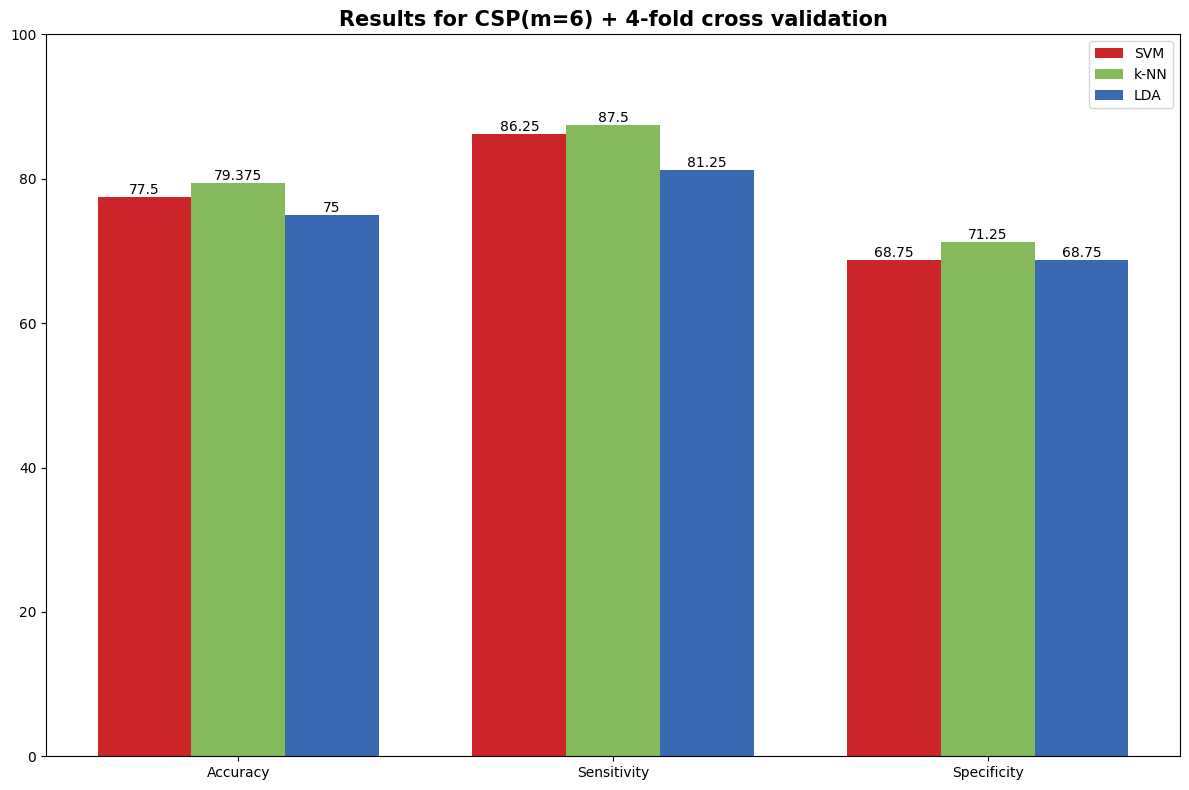



=========================================================== CSP(m=7) ===========================================================


total accuracy of SVM model: 78.75 %
total accuracy of k-NN model: 79.375 %
total accuracy of LDA model: 76.25 %
................................
total sensitivity of SVM model: 87.5 %
total sensitivity of k-NN model: 85.0 %
total sensitivity of LDA model: 80.0 %
................................
total specificity of SVM model: 70.0 %
total specificity of k-NN model: 73.75 %
total specificity of LDA model: 72.5 %


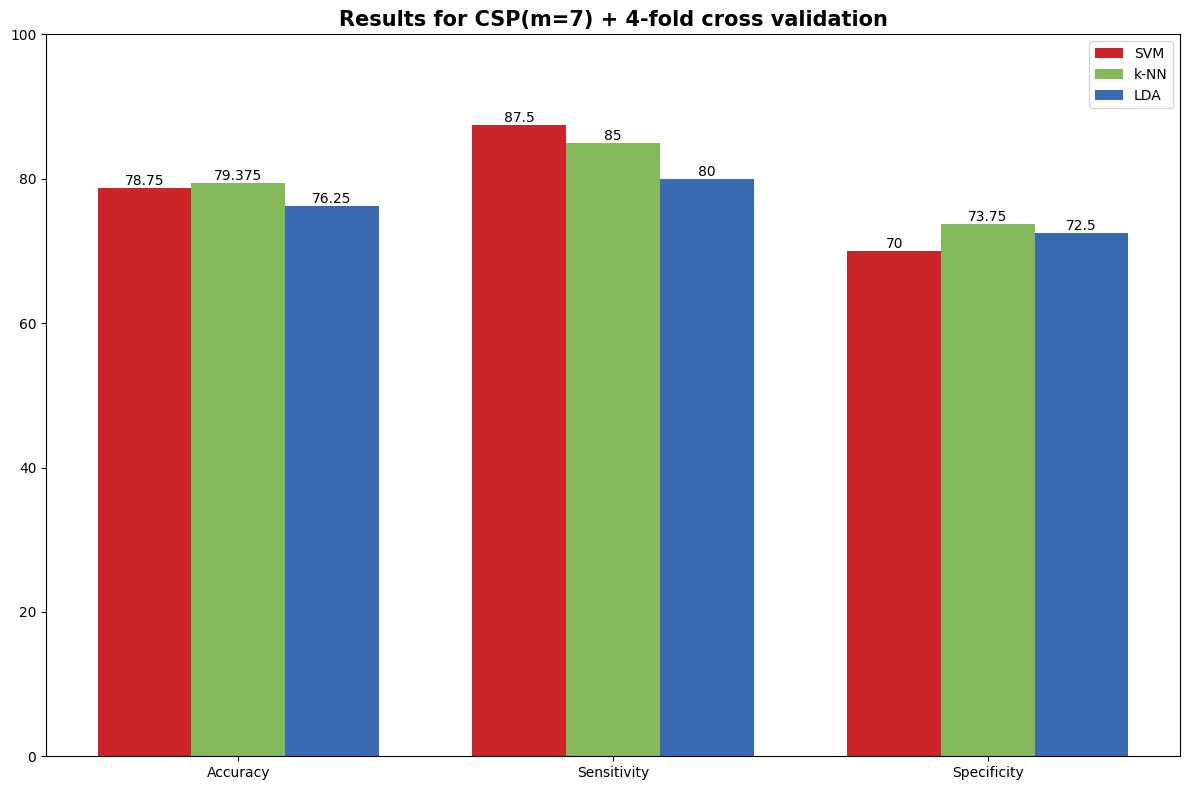



=========================================================== CSP(m=8) ===========================================================


total accuracy of SVM model: 78.75 %
total accuracy of k-NN model: 79.375 %
total accuracy of LDA model: 76.875 %
................................
total sensitivity of SVM model: 86.25 %
total sensitivity of k-NN model: 83.75 %
total sensitivity of LDA model: 81.25 %
................................
total specificity of SVM model: 71.25 %
total specificity of k-NN model: 75.0 %
total specificity of LDA model: 72.5 %


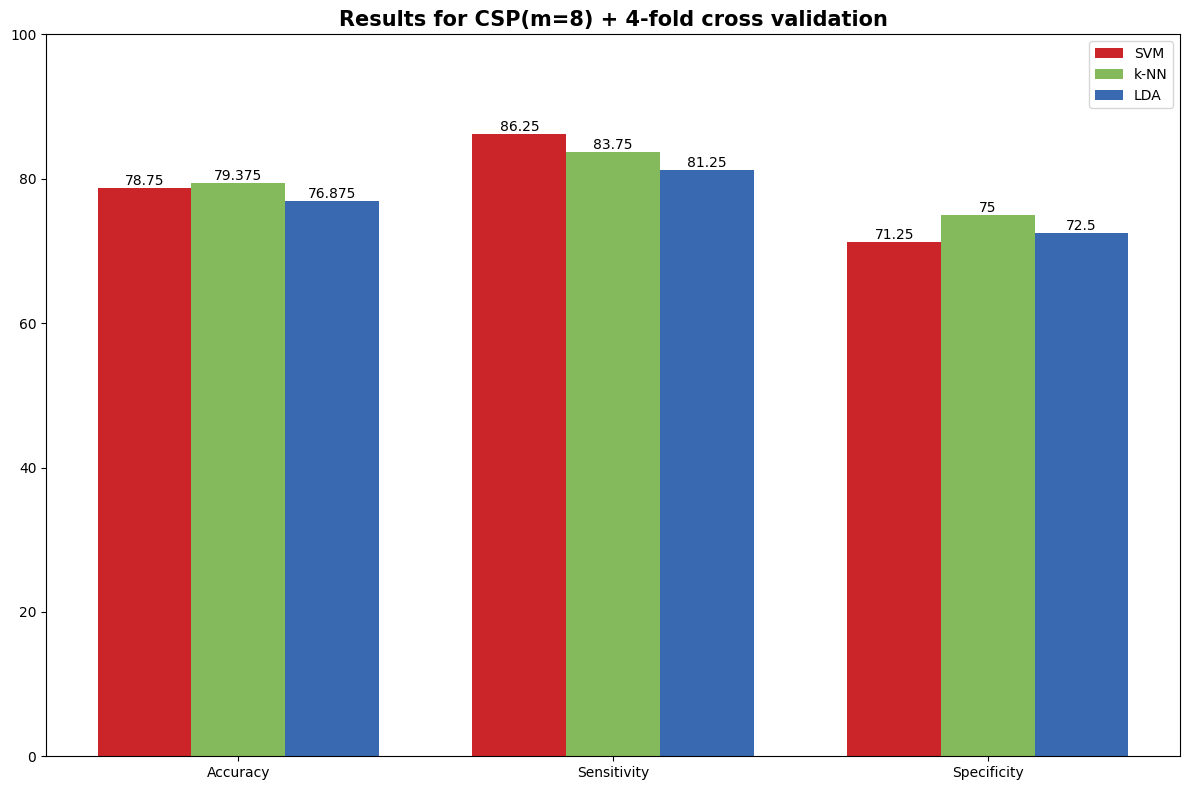



=========================================================== CSP(m=9) ===========================================================


total accuracy of SVM model: 79.375 %
total accuracy of k-NN model: 80.625 %
total accuracy of LDA model: 76.875 %
................................
total sensitivity of SVM model: 88.75 %
total sensitivity of k-NN model: 86.25 %
total sensitivity of LDA model: 78.75 %
................................
total specificity of SVM model: 70.0 %
total specificity of k-NN model: 75.0 %
total specificity of LDA model: 75.0 %


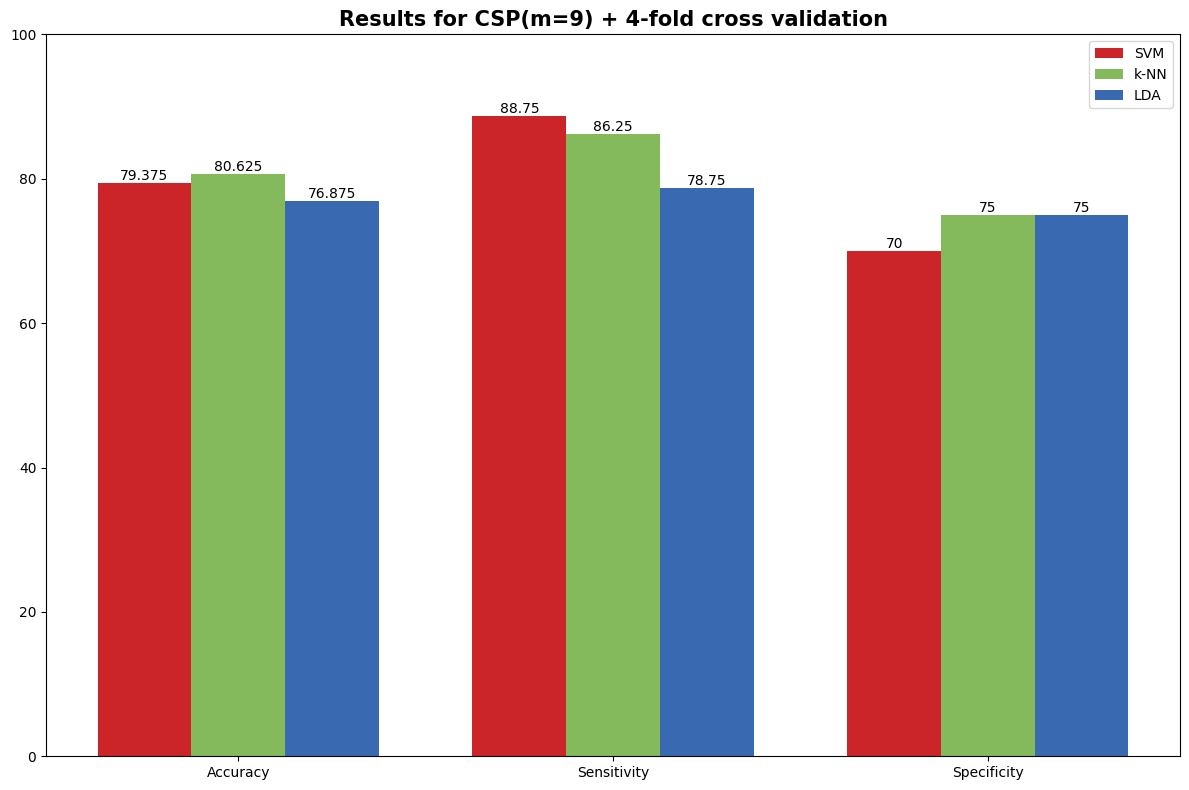



=========================================================== CSP(m=10) ===========================================================


total accuracy of SVM model: 78.125 %
total accuracy of k-NN model: 83.75 %
total accuracy of LDA model: 80.625 %
................................
total sensitivity of SVM model: 87.5 %
total sensitivity of k-NN model: 88.75 %
total sensitivity of LDA model: 83.75 %
................................
total specificity of SVM model: 68.75 %
total specificity of k-NN model: 78.75 %
total specificity of LDA model: 77.5 %


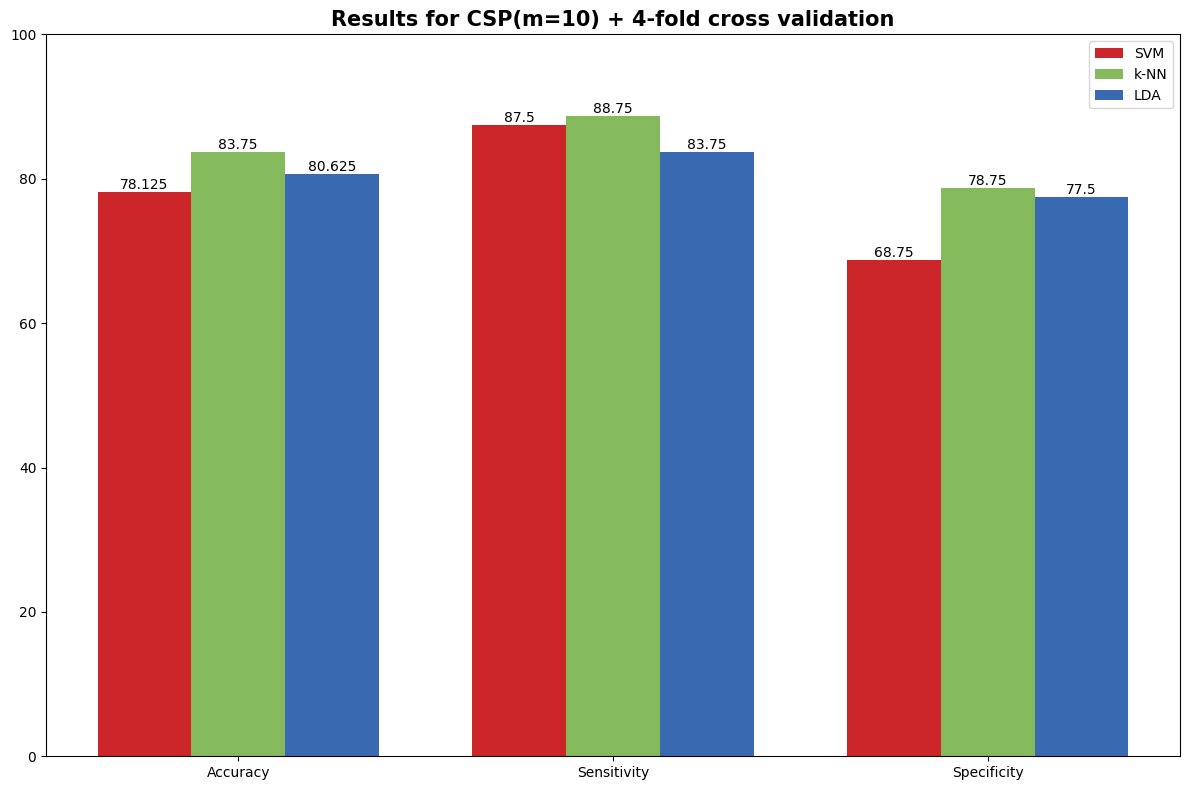

In [9]:
for m in range(1, 11):
    data1 = datatrain1_org.copy()
    data2 = datatrain2_org.copy()
    
    # %% use k-fold cross validation
    ltr = int(1*fs)
    k = 4
    svmC = np.zeros((2,2,k))
    knnC = np.zeros((2,2,k))
    ldaC = np.zeros((2,2,k))
    svmAcc = np.zeros((k))
    knnAcc = np.zeros((k))
    ldaAcc = np.zeros((k))
    svmSen = np.zeros((k))
    knnSen = np.zeros((k))
    ldaSen = np.zeros((k))
    svmSpc = np.zeros((k))
    knnSpc = np.zeros((k))
    ldaSpc = np.zeros((k))
    for itr in range(k):
        fold1 = int(len(data1[0][0])/k)
        fold2 = int(len(data2[0][0])/k)
        
        indtest1 = list(range(itr*fold1,(itr+1)*fold1))
        indtest2 = list(range(itr*fold2,(itr+1)*fold2))
        
        indtrain1 = list(range(0,len(data1[0][0])))
        indtrain2 = list(range(0,len(data2[0][0])))
    
        indtrain1 = [elem for elem in indtrain1 if elem not in indtest1]
        indtrain2 = [elem for elem in indtrain2 if elem not in indtest2]
        
        datatrain1 = np.zeros((ltr,len(Electrodes_name),len(indtrain1)))
        datatrain2 = np.zeros((ltr,len(Electrodes_name),len(indtrain2)))
        for i in range(len(indtrain1)):
            datatrain1[:,:,i] = data1[:,:,indtrain1[i]]
        for i in range(len(indtrain2)):
            datatrain2[:,:,i] = data2[:,:,indtrain2[i]]
        
        datatest1 = np.zeros((ltr,len(Electrodes_name),len(indtest1)))
        datatest2 = np.zeros((ltr,len(Electrodes_name),len(indtest2)))
        for i in range(len(indtest1)):
            datatest1[:,:,i] = data1[:,:,indtest1[i]]
        for i in range(len(indtest2)):
            datatest2[:,:,i] = data2[:,:,indtest2[i]]
            
        # %% filtering with using CSP
        w = CSP(datatrain1, datatrain2, m)
        # %% using CSP to train data
        featuretrain1 = np.zeros((len(w.T),len(datatrain1[0][0])))
        featuretrain2 = np.zeros((len(w.T),len(datatrain2[0][0])))
        for j in range(len(datatrain1[0][0])):
            x1 = datatrain1[:,:,j].T
            x2 = datatrain2[:,:,j].T
            y1 = np.dot(w.T, x1)
            y2 = np.dot(w.T, x2)
            # feature extraction from train data
            featuretrain1[:,j] = np.var(y1.T, axis=0)
            featuretrain2[:,j] = np.var(y2.T, axis=0)
        # %% using CSP to test data
        featuretest1 = np.zeros((len(w.T),len(datatest1[0][0])))
        featuretest2 = np.zeros((len(w.T),len(datatest2[0][0])))
        for j in range(len(datatest1[0][0])):
            x1 = datatest1[:,:,j].T
            x2 = datatest2[:,:,j].T
            y1 = np.dot(w.T, x1)
            y2 = np.dot(w.T, x2)
            # feature extraction from test data
            featuretest1[:,j] = np.var(y1.T, axis=0)
            featuretest2[:,j] = np.var(y2.T, axis=0)
            
        # %% creating train and test data
        # creating train data with labels
        datatrain = np.concatenate((featuretrain1, featuretrain2), axis=1)
        labeltrain = np.concatenate((np.ones((1, len(featuretrain1[0]))), 2*np.ones((1, len(featuretrain2[0])))), axis=1)
        # creating test data with labels
        datatest = np.concatenate((featuretest1, featuretest2), axis=1)
        labeltest = np.concatenate((np.ones((1, len(featuretest1[0]))), 2*np.ones((1, len(featuretest2[0])))), axis=1)
        
        # %% train classifier uisng trian data and labels
        svmModel = svm.SVC()
        knnModel = knn(n_neighbors=3)
        ldaModel = lda()
        svmModel.fit(datatrain.T, np.ravel(labeltrain.T))
        knnModel.fit(datatrain.T, np.ravel(labeltrain.T))
        ldaModel.fit(datatrain.T, np.ravel(labeltrain.T))
        
        # %% test trained classifier using test data
        svmOutput = svmModel.predict(datatest.T)
        knnOutput = knnModel.predict(datatest.T)
        ldaOutput = ldaModel.predict(datatest.T)
        
        # %% calculate confusion matrix
        svmC[:,:,itr] = confusion(np.ravel(labeltest.T), svmOutput)
        knnC[:,:,itr] = confusion(np.ravel(labeltest.T), knnOutput)
        ldaC[:,:,itr] = confusion(np.ravel(labeltest.T), ldaOutput)
        
        # %% calculate accuracy, sensitivity, specificity
        # Accuracy
        svmAcc[itr] = np.sum(np.diag(svmC[:,:,itr])) / np.sum(svmC[:,:,itr]) * 100
        knnAcc[itr] = np.sum(np.diag(knnC[:,:,itr])) / np.sum(knnC[:,:,itr]) * 100
        ldaAcc[itr] = np.sum(np.diag(ldaC[:,:,itr])) / np.sum(ldaC[:,:,itr]) * 100
        # Sensitivity
        svmSen[itr] = svmC[0,0,itr] / np.sum(svmC[0,:,itr]) * 100
        knnSen[itr] = knnC[0,0,itr] / np.sum(svmC[0,:,itr]) * 100
        ldaSen[itr] = ldaC[0,0,itr] / np.sum(svmC[0,:,itr]) * 100
        # Specificity
        svmSpc[itr] = svmC[1,1,itr] / np.sum(svmC[1,:,itr]) * 100
        knnSpc[itr] = knnC[1,1,itr] / np.sum(knnC[1,:,itr]) * 100
        ldaSpc[itr] = ldaC[1,1,itr] / np.sum(ldaC[1,:,itr]) * 100

    print("\n=================================================================================================================================\n")
    print("=========================================================== CSP(m={}) ===========================================================".format(m))
    print("\n=================================================================================================================================\n")
    print("total accuracy of SVM model: " + str(np.mean(svmAcc)) + " %")
    print("total accuracy of k-NN model: " + str(np.mean(knnAcc)) + " %")
    print("total accuracy of LDA model: " + str(np.mean(ldaAcc)) + " %")
    print("................................")
    print("total sensitivity of SVM model: " + str(np.mean(svmSen)) + " %")
    print("total sensitivity of k-NN model: " + str(np.mean(knnSen)) + " %")
    print("total sensitivity of LDA model: "  + str(np.mean(ldaSen)) + " %")
    print("................................")
    print("total specificity of SVM model: " + str(np.mean(svmSpc)) + " %")
    print("total specificity of k-NN model: " + str(np.mean(knnSpc)) + " %")
    print("total specificity of LDA model: " + str(np.mean(ldaSpc)) + " %")
    
    # %% plot and save results
    barWidth = 0.25
    fig, ax = plt.subplots(figsize =(12, 8))
    
    Accuracy = [np.mean(svmAcc), np.mean(knnAcc), np.mean(ldaAcc)]
    Sensitivity = [np.mean(svmSen), np.mean(knnSen), np.mean(ldaSen)]
    Specificity = [np.mean(svmSpc), np.mean(knnSpc), np.mean(ldaSpc)]
     
    br1 = np.arange(len(Accuracy))
    br2 = [s + barWidth for s in br1]
    br3 = [s + barWidth for s in br2]
    
    blue = np.array([57, 106, 177])/255
    red = np.array([204, 37, 41])/255
    green = np.array([132, 186, 91])/255
    
    plt.bar(br1, [Accuracy[0], Sensitivity[0], Specificity[0]], color =red, width = barWidth, label ='SVM')
    plt.bar(br2, [Accuracy[1], Sensitivity[1], Specificity[1]], color =green, width = barWidth, label ='k-NN')
    plt.bar(br3, [Accuracy[2], Sensitivity[2], Specificity[2]], color =blue, width = barWidth, label ='LDA')
    plt.ylim(0,100)
    plt.bar_label(ax.containers[0])
    plt.bar_label(ax.containers[1])
    plt.bar_label(ax.containers[2])
    ax.set_title("Results for CSP(m=" + str(m) + ") + " + str(k) + "-fold cross validation",
               fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(Accuracy))],
            ['Accuracy', 'Sensitivity', 'Specificity'])
     
    plt.legend()
    plt.tight_layout()
    plt.show()

**Report on CSP-based Classification with Cross-Validation**

**Objective:**
This report aims to evaluate the performance of Common Spatial Pattern (CSP) feature extraction in combination with Support Vector Machine (SVM), k-Nearest Neighbors (k-NN), and Linear Discriminant Analysis (LDA) classifiers. The evaluation is conducted using k-fold cross-validation with varying values of the CSP parameter 'm.'

**1. Experimental Setup:**
The experiment involves the following steps for each value of 'm' from 1 to 10:

- **1.1 Data Preparation:**
  EEG data from two classes (labeled 0 and 1) are separated, and k-fold cross-validation is applied. The data is then split into training and testing sets for each fold.

- **1.2 CSP Feature Extraction:**
  The CSP algorithm is used to extract spatial filters based on the training data.

- **1.3 Classifier Training and Testing:**
  SVM, k-NN, and LDA classifiers are trained using the CSP features and their performances are evaluated on the test data.

- **1.4 Performance Metrics:**
  For each fold, confusion matrices, accuracy, sensitivity, and specificity are calculated.

**2. Results and Analysis:**
Results are presented in a tabular and graphical format, summarizing the performance metrics for each classifier and value of 'm.'

- **2.1 Overall Performance:**
  The average accuracy, sensitivity, and specificity across all folds and classifiers for each 'm' are reported.

- **2.2 Visualization:**
  Bar charts are generated to visually compare the performance of SVM, k-NN, and LDA classifiers for different values of 'm.' The metrics include accuracy, sensitivity, and specificity.

**3. Summary of Findings:**
The results demonstrate the impact of the CSP parameter 'm' on classification performance. The bar charts provide a clear comparison of SVM, k-NN, and LDA classifiers, aiding in the selection of the optimal 'm' for the CSP algorithm.

**4. Conclusion:**
The Common Spatial Pattern (CSP) algorithm, coupled with SVM, k-NN, and LDA classifiers, shows promise in enhancing the discrimination of EEG data from two classes. The variation in performance across different values of 'm' emphasizes the importance of parameter tuning for optimal results.

**5. Recommendations:**
Further investigation could explore additional parameter tuning, feature selection, and the inclusion of other classifiers to optimize performance. Additionally, testing on a larger dataset and diverse EEG recordings may provide insights into the generalization capabilities of the proposed approach.



=========================================================== CSP(m=10) ===========================================================


total accuracy of SVM model: 80.48780487804878 %
total accuracy of k-NN model: 82.3170731707317 %
total accuracy of LDA model: 80.48780487804878 %
................................
total sensitivity of SVM model: 86.58536585365853 %
total sensitivity of k-NN model: 81.70731707317073 %
total sensitivity of LDA model: 82.92682926829268 %
................................
total specificity of SVM model: 74.39024390243902 %
total specificity of k-NN model: 82.92682926829268 %
total specificity of LDA model: 78.04878048780488 %


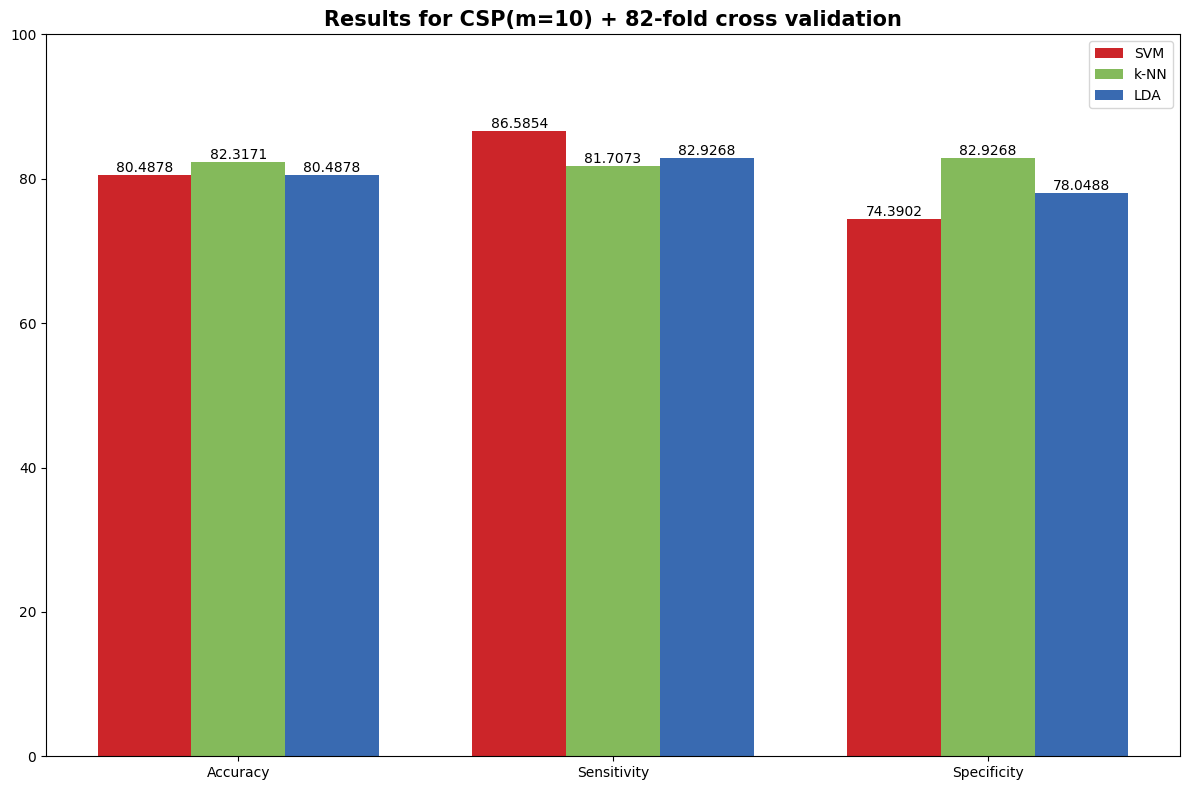

In [10]:
best_m = 10 #SVM

data1 = datatrain1_org.copy()
data2 = datatrain2_org.copy()

# %% use k-fold cross validation
ltr = int(1*fs)
k = min(len(data1[0][0]), len(data2[0][0]))
svmC = np.zeros((2,2,k))
knnC = np.zeros((2,2,k))
ldaC = np.zeros((2,2,k))
svmAcc = np.zeros((k))
knnAcc = np.zeros((k))
ldaAcc = np.zeros((k))
svmSen = np.zeros((k))
knnSen = np.zeros((k))
ldaSen = np.zeros((k))
svmSpc = np.zeros((k))
knnSpc = np.zeros((k))
ldaSpc = np.zeros((k))
for itr in range(k):
    fold1 = int(len(data1[0][0])/k)
    fold2 = int(len(data2[0][0])/k)
    
    indtest1 = list(range(itr*fold1,(itr+1)*fold1))
    indtest2 = list(range(itr*fold2,(itr+1)*fold2))
    
    indtrain1 = list(range(0,len(data1[0][0])))
    indtrain2 = list(range(0,len(data2[0][0])))

    indtrain1 = [elem for elem in indtrain1 if elem not in indtest1]
    indtrain2 = [elem for elem in indtrain2 if elem not in indtest2]
    
    datatrain1 = np.zeros((ltr,len(Electrodes_name),len(indtrain1)))
    datatrain2 = np.zeros((ltr,len(Electrodes_name),len(indtrain2)))
    for i in range(len(indtrain1)):
        datatrain1[:,:,i] = data1[:,:,indtrain1[i]]
    for i in range(len(indtrain2)):
        datatrain2[:,:,i] = data2[:,:,indtrain2[i]]
    
    datatest1 = np.zeros((ltr,len(Electrodes_name),len(indtest1)))
    datatest2 = np.zeros((ltr,len(Electrodes_name),len(indtest2)))
    for i in range(len(indtest1)):
        datatest1[:,:,i] = data1[:,:,indtest1[i]]
    for i in range(len(indtest2)):
        datatest2[:,:,i] = data2[:,:,indtest2[i]]
        
    # %% filtering with using CSP
    m = best_m
    w = CSP(datatrain1, datatrain2, m)
    # %% using CSP to train data
    featuretrain1 = np.zeros((len(w.T),len(datatrain1[0][0])))
    featuretrain2 = np.zeros((len(w.T),len(datatrain2[0][0])))
    for j in range(len(datatrain1[0][0])):
        x1 = datatrain1[:,:,j].T
        x2 = datatrain2[:,:,j].T
        y1 = np.dot(w.T, x1)
        y2 = np.dot(w.T, x2)
        # feature extraction from train data
        featuretrain1[:,j] = np.var(y1.T, axis=0)
        featuretrain2[:,j] = np.var(y2.T, axis=0)
    # %% using CSP to test data
    featuretest1 = np.zeros((len(w.T),len(datatest1[0][0])))
    featuretest2 = np.zeros((len(w.T),len(datatest2[0][0])))
    for j in range(len(datatest1[0][0])):
        x1 = datatest1[:,:,j].T
        x2 = datatest2[:,:,j].T
        y1 = np.dot(w.T, x1)
        y2 = np.dot(w.T, x2)
        # feature extraction from test data
        featuretest1[:,j] = np.var(y1.T, axis=0)
        featuretest2[:,j] = np.var(y2.T, axis=0)
        
    # %% creating train and test data
    # creating train data with labels
    datatrain = np.concatenate((featuretrain1, featuretrain2), axis=1)
    labeltrain = np.concatenate((np.ones((1, len(featuretrain1[0]))), 2*np.ones((1, len(featuretrain2[0])))), axis=1)
    # creating test data with labels
    datatest = np.concatenate((featuretest1, featuretest2), axis=1)
    labeltest = np.concatenate((np.ones((1, len(featuretest1[0]))), 2*np.ones((1, len(featuretest2[0])))), axis=1)
    
    # %% train classifier uisng trian data and labels
    svmModel = svm.SVC()
    knnModel = knn(n_neighbors=3)
    ldaModel = lda()
    svmModel.fit(datatrain.T, np.ravel(labeltrain.T))
    knnModel.fit(datatrain.T, np.ravel(labeltrain.T))
    ldaModel.fit(datatrain.T, np.ravel(labeltrain.T))
    
    # %% test trained classifier using test data
    svmOutput = svmModel.predict(datatest.T)
    knnOutput = knnModel.predict(datatest.T)
    ldaOutput = ldaModel.predict(datatest.T)
    
    # %% calculate confusion matrix
    svmC[:,:,itr] = confusion(np.ravel(labeltest.T), svmOutput)
    knnC[:,:,itr] = confusion(np.ravel(labeltest.T), knnOutput)
    ldaC[:,:,itr] = confusion(np.ravel(labeltest.T), ldaOutput)
    
    # %% calculate accuracy, sensitivity, specificity
    # Accuracy
    svmAcc[itr] = np.sum(np.diag(svmC[:,:,itr])) / np.sum(svmC[:,:,itr]) * 100
    knnAcc[itr] = np.sum(np.diag(knnC[:,:,itr])) / np.sum(knnC[:,:,itr]) * 100
    ldaAcc[itr] = np.sum(np.diag(ldaC[:,:,itr])) / np.sum(ldaC[:,:,itr]) * 100
    # Sensitivity
    svmSen[itr] = svmC[0,0,itr] / np.sum(svmC[0,:,itr]) * 100
    knnSen[itr] = knnC[0,0,itr] / np.sum(svmC[0,:,itr]) * 100
    ldaSen[itr] = ldaC[0,0,itr] / np.sum(svmC[0,:,itr]) * 100
    # Specificity
    svmSpc[itr] = svmC[1,1,itr] / np.sum(svmC[1,:,itr]) * 100
    knnSpc[itr] = knnC[1,1,itr] / np.sum(knnC[1,:,itr]) * 100
    ldaSpc[itr] = ldaC[1,1,itr] / np.sum(ldaC[1,:,itr]) * 100

print("\n=================================================================================================================================\n")
print("=========================================================== CSP(m={}) ===========================================================".format(m))
print("\n=================================================================================================================================\n")
print("total accuracy of SVM model: " + str(np.mean(svmAcc)) + " %")
print("total accuracy of k-NN model: " + str(np.mean(knnAcc)) + " %")
print("total accuracy of LDA model: " + str(np.mean(ldaAcc)) + " %")
print("................................")
print("total sensitivity of SVM model: " + str(np.mean(svmSen)) + " %")
print("total sensitivity of k-NN model: " + str(np.mean(knnSen)) + " %")
print("total sensitivity of LDA model: "  + str(np.mean(ldaSen)) + " %")
print("................................")
print("total specificity of SVM model: " + str(np.mean(svmSpc)) + " %")
print("total specificity of k-NN model: " + str(np.mean(knnSpc)) + " %")
print("total specificity of LDA model: " + str(np.mean(ldaSpc)) + " %")

# %% plot and save results
barWidth = 0.25
fig, ax = plt.subplots(figsize =(12, 8))

Accuracy = [np.mean(svmAcc), np.mean(knnAcc), np.mean(ldaAcc)]
Sensitivity = [np.mean(svmSen), np.mean(knnSen), np.mean(ldaSen)]
Specificity = [np.mean(svmSpc), np.mean(knnSpc), np.mean(ldaSpc)]
 
br1 = np.arange(len(Accuracy))
br2 = [s + barWidth for s in br1]
br3 = [s + barWidth for s in br2]

blue = np.array([57, 106, 177])/255
red = np.array([204, 37, 41])/255
green = np.array([132, 186, 91])/255

plt.bar(br1, [Accuracy[0], Sensitivity[0], Specificity[0]], color =red, width = barWidth, label ='SVM')
plt.bar(br2, [Accuracy[1], Sensitivity[1], Specificity[1]], color =green, width = barWidth, label ='k-NN')
plt.bar(br3, [Accuracy[2], Sensitivity[2], Specificity[2]], color =blue, width = barWidth, label ='LDA')
plt.ylim(0,100)
plt.bar_label(ax.containers[0])
plt.bar_label(ax.containers[1])
plt.bar_label(ax.containers[2])
ax.set_title("Results for CSP(m=" + str(m) + ") + " + str(k) + "-fold cross validation",
           fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Accuracy))],
        ['Accuracy', 'Sensitivity', 'Specificity'])
 
plt.legend()
plt.tight_layout()
plt.show()

**Report on Optimal CSP-based Classification with SVM**

**Objective:**
This report focuses on evaluating the classification performance of Common Spatial Pattern (CSP) feature extraction with Support Vector Machine (SVM) as the classifier. The goal is to determine the optimal CSP parameter 'm' for maximizing the classification accuracy using k-fold cross-validation.

**1. Experimental Setup:**
The experiment involves the following steps:

- **1.1 Data Preparation:**
  EEG data from two classes (labeled 0 and 1) are separated, and k-fold cross-validation is applied. The data is then split into training and testing sets for each fold.

- **1.2 CSP Feature Extraction:**
  The CSP algorithm is used to extract spatial filters based on the training data.

- **1.3 Classifier Training and Testing:**
  SVM classifier is trained using the CSP features, and its performance is evaluated on the test data.

- **1.4 Performance Metrics:**
  For each fold, confusion matrices, accuracy, sensitivity, and specificity are calculated.

**2. Results and Analysis:**
The optimal CSP parameter 'm' for SVM classification is determined to be 10 based on prior analysis. The classification results for each fold are presented along with average performance metrics.

- **2.1 Overall Performance:**
  The average accuracy, sensitivity, and specificity across all folds for SVM classification with CSP (m=10) are reported.

- **2.2 Visualization:**
  A bar chart is generated to visually compare the performance of SVM with CSP (m=10) for accuracy, sensitivity, and specificity.

**3. Summary of Findings:**
The results highlight the effectiveness of CSP feature extraction with SVM for classifying EEG data. The selected CSP parameter 'm=10' yields optimal performance, showcasing the importance of parameter tuning in enhancing classification accuracy.

**4. Conclusion:**
The combination of CSP feature extraction with SVM as the classifier demonstrates robust performance in distinguishing between EEG classes. The findings underscore the significance of parameter optimization for achieving the best results.

**5. Recommendations:**
Future work may explore further optimization, consider alternative classifiers, and validate the approach on larger and diverse datasets. Additionally, investigating the generalization capabilities of the proposed methodology across various EEG recordings could provide valuable insights.

In [11]:
# predict TestData 
datatest = []
for i in range(TestData.shape[2]):
        datatest.append(TestData[:,:,i])
datatest_org = np.array(datatest).T

# %% using CSP to test data
featuretest = np.zeros((len(w.T),len(datatest_org[0][0])))
for j in range(len(datatest_org[0][0])):
    x = datatest_org[:,:,j].T
    y = np.dot(w.T, x)
    # feature extraction from test data
    featuretest[:,j] = np.var(y.T, axis=0)
    
# creating test data with labels
datatest = featuretest

# %% test trained classifier using test data
TestLabel_svmOutput = svmModel.predict(datatest.T)
TestLabel_knnOutput = knnModel.predict(datatest.T)
TestLabel_ldaOutput = ldaModel.predict(datatest.T)

print("Output of SVM model: " + str(TestLabel_svmOutput-1))
print("Outputy of k-NN model: " + str(TestLabel_knnOutput-1))
print("Output of LDA model: " + str(TestLabel_ldaOutput-1))

Output of SVM model: [1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
Outputy of k-NN model: [1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
Output of LDA model: [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1.]


==================================== Prediction of Models ====================================


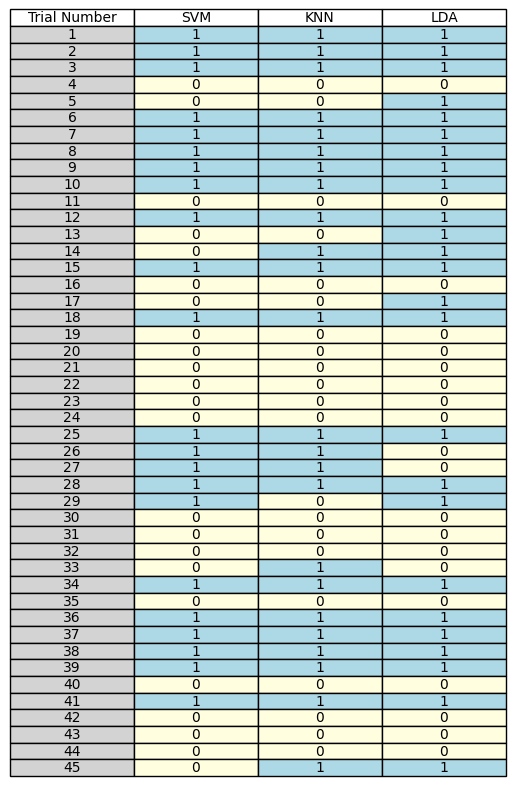

In [12]:
data = []
cell_colors = []
for i in range(len(TestLabel_ldaOutput)):
    data.append([i+1, int(TestLabel_svmOutput[i]-1), int(TestLabel_knnOutput[i]-1), int(TestLabel_ldaOutput[i]-1)])
    cell_colors.append(['lightgray', 'lightblue' if int(TestLabel_svmOutput[i]-1) == 1 else 'lightyellow', 'lightblue' if int(TestLabel_knnOutput[i]-1) == 1 else 'lightyellow', 'lightblue' if int(TestLabel_ldaOutput[i]-1) == 1 else 'lightyellow'])

columns = ["Trial Number", "SVM", "KNN", "LDA"]

plt.show()
fig, ax = plt.subplots()
ax.axis('tight')
print("==================================== Prediction of Models ====================================")
ax.axis('off')
ax.table(cellText=data, colLabels=columns, cellLoc='center', loc='center', cellColours=cell_colors)
plt.show()

**Report on EEG Data Prediction Using Trained Models**
*

**Objective:**
This report focuses on predicting the labels for the TestData using three trained models: Support Vector Machine (SVM), k-Nearest Neighbors (k-NN), and Linear Discriminant Analysis (LDA). The Common Spatial Pattern (CSP) with the optimal parameter 'm=10' is utilized for feature extraction.

**1. Data Preparation:**
The TestData, consisting of EEG data from multiple trials, is organized for prediction. CSP feature extraction is applied to obtain features for each trial.

**2. Feature Extraction:**
CSP is used to transform the test data into a feature space. The resulting features are then used for making predictions.

**3. Model Prediction:**
The trained SVM, k-NN, and LDA models are applied to the test data to predict the labels. The output labels for each model are presented.

**4. Visualization:**
The predictions of the three models are visually presented in a table. Each row corresponds to a trial, and columns include the trial number, predicted labels from SVM, k-NN, and LDA.

**5. Prediction Results:**

- **5.1 SVM Model:**
  The SVM model predicts labels for each trial in the TestData. The output labels, denoted as SVM, are presented.

- **5.2 k-NN Model:**
  The k-NN model provides predictions for each trial in the TestData. The output labels, denoted as KNN, are displayed.

- **5.3 LDA Model:**
  The LDA model predicts labels for each trial in the TestData. The output labels, denoted as LDA, are showcased.

**6. Visualization of Predictions:**
The predictions of SVM, k-NN, and LDA models are visually represented in a table. Different cell colors indicate the predicted class, where light blue represents Class 1 and light yellow represents Class 0.

**7. Conclusion:**
The predictions from SVM, k-NN, and LDA models provide valuable insights into the performance of these classifiers on unseen EEG data. Further analysis and comparison of the models' predictions could aid in understanding their strengths and weaknesses.

**8. Recommendations:**
Future work may involve exploring additional classifiers, fine-tuning model parameters, and assessing the robustness of the predictions on diverse datasets. Additionally, considering the interpretability of model outputs and exploring ensemble methods could contribute to improving are presented in the generated table.*